In [60]:
import os
import pandas as pd
import tensorflow as tf
import keras
import numpy as np

from keras import regularizers
from keras.layers import Flatten
import collections
from sklearn.model_selection import train_test_split
import warnings
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv1D,Dense,Dropout,MaxPooling1D,ZeroPadding1D, Flatten,BatchNormalization,Lambda
from keras.models import load_model

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import doc2vec

In [2]:
# Doc2Vec 모델 불러오기
p2v_model = doc2vec.Doc2Vec.load('C:/Users/dowoon/Desktop/리영 유사도/p2v_128_all_1.model')
# 데이터 불러오기
data=pd.read_csv('C:/Users/dowoon/Desktop/리영 유사도/all_after_filter.csv')
person_id=data['PERSON_ID'].unique()
data.sort_values('RECU_FR_DT',inplace=True)
data.drop(columns=['KEY_SEQ','RECU_FR_DT','MAIN_ICDnorm'],inplace=True)
person_id=person_id.tolist()
train_label_df=pd.read_csv('C:/Users/dowoon/Desktop/유사도 프로젝트/project/label_train1.csv')
test_label_df=pd.read_csv('C:/Users/dowoon/Desktop/유사도 프로젝트/project/label_test1.csv')
train_label_df.iloc[:,2]=train_label_df.iloc[:,2].astype('float32')
test_label_df.iloc[:,2]=test_label_df.iloc[:,2].astype('float32')
person_doc_dict={key:value for value,key in enumerate(person_id)}

In [3]:
# 임베딩 값 불러오기
embedding=np.load('C:/Users/dowoon/Desktop/리영 유사도/embedding_metrix_1.npy')

In [5]:
embedding

array([[[ 1.4593198 ,  0.11443343, -0.6118474 , ..., -0.9748829 ,
          0.21348347,  0.5980873 ],
        [ 1.1487911 ,  0.32831365, -0.05537921, ..., -0.2772788 ,
         -0.08820643,  0.2321483 ],
        [ 0.5814154 ,  0.05676644,  0.17004086, ..., -0.19627106,
          0.27805322,  0.62268984],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.5045696 ,  0.16370758,  0.44952714, ..., -0.42486086,
          0.19578895,  0.47860295],
        [ 0.41227153, -0.10917952,  0.39579263, ..., -0.15159266,
          0.31917372,  0.36333698],
        [ 0.44353372, -0.06878203,  0.3854101 , ..., -0.36117232,
          0.2628429 ,  0.33912316],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [4]:
# similarity learning을 진행하기 위한 데이터 셋 만들기
class CSV_dataset():
    def __init__(self, label_df, person_doc_dict, embedding):
        super(CSV_dataset, self).__init__()
        self.label_df = label_df
        self.person_doc_dict = person_doc_dict
        self.embedding = embedding
    def __getitem__(self, item):
        person_1 = self.label_df.iloc[item, 0]
        person_2 = self.label_df.iloc[item, 1]
        person_1_id=self.person_doc_dict[person_1]
        person_2_id=self.person_doc_dict[person_2]
        person_1_vec =self.embedding[person_1_id]
        person_2_vec =self.embedding[person_2_id]
        similarity = self.label_df.iloc[item, 2]
        
        return person_1_vec, person_2_vec, similarity
    def __len__(self):
        return len(self.label_df)

In [6]:
# specify the shape of the inputs for our network
IMG_SHAPE = (480, 128)
# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 100
# define the path to the base output directory
BASE_OUTPUT = "output"

MODEL_PATH = os.path.sep.join([BASE_OUTPUT,
	"contrastive_siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT,
	"contrastive_plot.png"])

In [7]:
# 두 환자의 representation vector를 얻기위한 model 생성
def build_siamese_model(inputShape):
    inputs = Input(inputShape)
    x = Conv1D(64, 10, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(64, 7, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(64, 5, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, 10, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D( )(x)
    x = Dropout(0.3)(x)
    

    x = Conv1D(128, 7, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, 5, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, 5, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)

    
    outputs = Flatten()(x)
    model = Model(inputs, outputs)
    return model

In [8]:
# 두 vactor 사이에 L2 거리구하기
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [9]:
# loss fuction 만들기
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    return loss

In [10]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
# Feature vector 만들기
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# 두 feature vector간 거리구하기
distance = Lambda(euclidean_distance)([featsA,featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

In [11]:
print("[INFO] compiling model...")
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss=contrastive_loss, optimizer=opt)
from keras.models import load_model
model.load_weights("C:/Users/dowoon/Desktop/유사도 프로젝트/project/sam_model.h5")

[INFO] compiling model...


In [26]:
data = pd.read_csv('C:/Users/dowoon/Desktop/유사도 프로젝트/project1/final_label.csv')

In [27]:
# empty 즉 합병증이 없는 환자 0으로 채우기
data=data.fillna(0)

In [28]:
# cluster 만들기 0번 cluster는 모든 합병증이 없는 클러스터이고 나머지 cluster는 각 cluster의 합병증이 존지하는 환자들을 배치함
cluster0=data[data['FOOT'] == 0]
for i in ['MULTI','HYP','KDY','NEURO','HRT','STK']:
    cluster0=cluster0[cluster0[i] == 0]
cluster1=data[data['FOOT'] == 1]
cluster2=data[data['MULTI'] == 1]
cluster3=data[data['HYP'] == 1]
cluster4=data[data['KDY'] == 1]
cluster5=data[data['NEURO'] == 1]
cluster6=data[data['HRT'] == 1]
cluster7=data[data['STK'] == 1]

In [29]:
# 각 cluster 별 100명씩 sampling함
cluster0=cluster0.sample(n = 100)
cluster1=cluster1.sample(n = 100)
cluster2=cluster2.sample(n = 100)
cluster3=cluster3.sample(n = 100)
cluster4=cluster4.sample(n = 100)
cluster5=cluster5.sample(n = 100)
cluster6=cluster6.sample(n = 100)
cluster7=cluster7.sample(n = 100)

In [30]:
cluster0=cluster0['PERSON_ID'].tolist()
cluster1=cluster1['PERSON_ID'].tolist()
cluster2=cluster2['PERSON_ID'].tolist()
cluster3=cluster3['PERSON_ID'].tolist()
cluster4=cluster4['PERSON_ID'].tolist()
cluster5=cluster5['PERSON_ID'].tolist()
cluster6=cluster6['PERSON_ID'].tolist()
cluster7=cluster7['PERSON_ID'].tolist()

In [31]:
cluster=[cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7]

In [32]:
# cluser의 환자들의 환자 id에서 환자의 embedding 값으로 바꿈
clu_em = []
for clu in cluster:
    embe =[]
    for person_id in clu:
        person_1_id=person_doc_dict[person_id]
        person_vec = embedding[person_1_id]
        embe.append(person_vec)
    clu_em.append(embe)

In [33]:
# clustering 할 데이터 선택
a=data['PERSON_ID'].sample(n = 100)
per_test=a.tolist()

In [34]:
# clustering 할 데이터 embedding값으로 바꾸기
test_per = []
for person_id in per_test:
    test = []
    person_1_id=person_doc_dict[person_id]
    person_vec = embedding[person_1_id]
    for _ in range(100):
        test.append(person_vec)
    test_per.append(test)

In [35]:
# 각 데이터별 결과값 (두 데이터사이의 거리)
result = []
for test in test_per:
    re = []
    for clu in clu_em:
        clu = np.array(clu)
        test = np.array(test)
        pre=model.predict([clu,test])
        re.append(pre)
    result.append(re)

In [36]:
# 가장 많은 값 구하기
from collections import Counter
def most_common_top_1(candidates):
    assert isinstance(candidates, list)
    if len(candidates) == 0: return None
    return Counter(candidates).most_common(n=1)[0][0]

In [37]:
# KNN 클러스터링 기법을 이용함 
final_cluster = []
for test in result:
    clumin = []
    clu_list = []
    for clu in test:
        for i in clu:
            clu_list.append(clu[0])
    so = sorted(clu_list)
    so_list=[]
    for i in range(10):
        so_list.append(so[i])
    final_list =[]
    for so in so_list:
        for i in so:
            clu = clu_list.index(i) 
        clu = int((clu+1)//100)
        final_list.append(clu)
    clu=most_common_top_1(final_list)
    final_cluster.append(clu)

In [51]:
# clustering 결과값 보기
counts = 0
for per_id,clu in zip(per_test,final_cluster):
    x=data[data['PERSON_ID'] == per_id]
    if x.iloc[:,3+clu].values == 1:
        counts+=1
    elif (x.iloc[:,4].values ==
          clu) and (x.iloc[:,5].values == clu) and (x.iloc[:,6].values == clu) and (x.iloc[:,7].values == clu) and (x.iloc[:,8].values == clu) and (x.iloc[:,9].values == clu) and (x.iloc[:,10].values == clu):
        counts += 1
print(counts/100)

0.53


In [41]:
# random으로 했을때 결과값 보기
import random
ran_cluster = []
for _ in range(100):
    a = random.randint(0,7)
    ran_cluster.append(a)
count = 0

for per_id,clu in zip(per_test,ran_cluster):
    x=data[data['PERSON_ID'] == per_id]
    if x.iloc[:,3+clu].values == 1:
        count+=1
    elif (x.iloc[:,4].values == clu) and (x.iloc[:,5].values == clu) and (x.iloc[:,6].values == clu) and (x.iloc[:,7].values == clu) and (x.iloc[:,8].values == clu) and (x.iloc[:,9].values == clu) and (x.iloc[:,10].values == clu):
        count += 1
print(count/100)

0.19


In [47]:
df=pd.DataFrame({'person_id':per_test,'Cluster':final_cluster})

In [50]:
df.to_csv('C:/Users/dowoon/Desktop/리영 유사도/final_cluster.csv')

In [52]:
import matplotlib.pyplot as plt

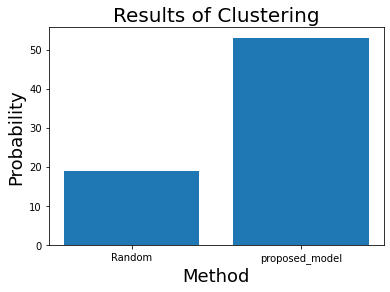

In [56]:
# clustering 결과 비교
index = ['Random','proposed_model']
value = [count,counts]
plt.bar(index,value)
plt.title('Results of Clustering', fontsize=20)
plt.xlabel('Method', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.show()



In [62]:
del data['GNL_NM_CD']
del data['SICK_SYMnorm']
del data['MAIN_ICDnorm']

In [109]:
data.sample(n = 100)

,PERSON_ID,FOOT,MULTI,HYP,KDY,NEURO,HRT,STK
35830,57952780,0.0,1.0,1.0,0.0,1.0,0.0,0.0
7722,18626426,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49828,77934561,1.0,1.0,0.0,0.0,0.0,0.0,0.0
49653,77626088,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50561,79187793,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
56204,87936954,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19312,32829228,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14826,27773510,0.0,1.0,0.0,0.0,0.0,0.0,0.0
54565,85456150,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:

person_1_id=person_doc_dict[87936954]
person_vec_1 = embedding[person_1_id]
person_vec_1 = np.array([person_vec_1])

person_2_id=person_doc_dict[32829228]
person_vec_2 = embedding[person_2_id]
person_vec_2 = np.array([person_vec_2])

model.predict([person_vec_1,person_vec_2])

array([[0.71851045]], dtype=float32)

In [87]:
person_vec_1

array([[ 0.31409794, -0.11088192,  0.025798  , ..., -0.33310983,
         0.21922897,  0.22704141],
       [ 0.28060517, -0.11564828, -0.02964489, ..., -0.21312429,
         0.15467432,  0.25061962],
       [ 0.35369354, -0.0203701 ,  0.07824197, ..., -0.3391111 ,
         0.22446765,  0.3074849 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)